In [1]:
from pricing import DiscountingCurve, Black, EquityForwardCurve, Call_Closed
import numpy as np
import matplotlib.pyplot as plt
from montecarlo import Monte_Carlo_Analisys

In [2]:
d = DiscountingCurve(reference=0,zero_rate=0.01)
f = EquityForwardCurve(spot = 100, reference=0,discounting_curve=d,repo_rates=0,dividend_yelds=0)
b = Black(volatility=0.2,forward_curve=f)

In [3]:
date = np.linspace(0.001,1,100)
S_t = b.simulate(fixings=date,Nsim=1e6)

In [4]:
payoff = b.Call_PayOff(S_t,100)*d(date)

In [5]:
x,mean,err = Monte_Carlo_Analisys(payoff,100)

In [6]:
real = Call_Closed(100,100,date,0.01,0,0.2)

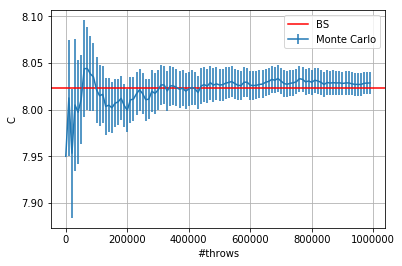

In [12]:
n = 90
plt.axhline(y=real[n], color = 'red',linestyle='-',label = 'BS')
plt.errorbar(x,mean.T[n],yerr=err.T[n],label = 'Monte Carlo')
plt.xlabel('#throws')
plt.ylabel('C')
plt.grid(True)
plt.legend()
plt.show()

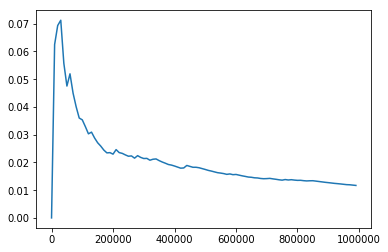

In [13]:
plt.plot(x,err.T[n])

In [ ]:
a = np.array([1,0,3])
b = np.array([2,3,0])
c = max(a.any(),b.any())

In [ ]:
c = np.maximum(a,b)

In [ ]:
c